## Business Analysis Challenge : NBA Hackathon 2019
#### Challenge : Business Analysis
#### Team Members : Sabarish Gopalakrishnan
#### College : Rochester Institute of Technology
#### Contact Details : sxg8458@rit.edu | sab030193@gmail.com | + 1 585 487 9698
#### Git/Medium : github.com/sabarish-g/ | medium.com/@sabarishg7 



In [1]:
#Importing all needed libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

### Reading the training and the holdout test set using pandas.

In [2]:
train = pd.read_csv('training_set.csv', encoding='ISO-8859-1')
holdout_test = pd.read_csv('holdout_set.csv', encoding='ISO-8859-1')

### Samples from the dataset.
Below is a glimpse of the data. The description column has a lot of information that we can extract. The next few functions will extract some information from the description column.

In [3]:
train.head()

,Engagements,Followers at Posting,Created,Type,Description
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...


In [4]:
for i in range(0,5):
    print('Description {} : {}'.format(i,train.Description[i]))

Description 0 : The @raptors bench trio of @sergeibaka @normanpowell4 & @fredvanvleet combine for 48 in Game 4!
Description 1 : @kyle_lowry7 pulls from deep for the @raptors in the 4th on TNT!
Description 2 : @k_mid22 with some english on the @bucks dime!
Description 3 : Kawhi punches it home with the left on TNT!
Description 4 : @giannis_an34 goes baseline early to rock the rim on TNT!


### Using time stamp information to extract time, day, month, year, holiday season, weekend.
#### The following function takes the 'Created' field from the dataset and extracts the year, month, day, day of the week, time of the season(playoffs, off season and regular), holida period(Thanksgiving and Christmas, New Year)

In [5]:
def get_time_variables(table):
    print('Extracting time information : ')
    table['time_of_day'] = pd.to_datetime(table['Created']).dt.hour
    table['year'] = pd.to_datetime(table['Created']).dt.year
    table['month'] = pd.to_datetime(table['Created']).dt.month
    table['day'] = pd.to_datetime(table['Created']).dt.day
    table['weekday'] = pd.to_datetime(table['Created']).dt.weekday_name
    table['weekend_flag'] = (table['weekday'].str.contains('Sunday') | table['weekday'].str.contains('Saturday'))
    table['time_of_season'] = np.where(((table['month']<4) | (table['month'] > 9)), 'Regular',
                           np.where(((table['month'] >= 4) & (table['month'] <7)),'Playoffs', 'offseason'))
    
    #extracting if the tweet was sent on Christmas, Thanksgiving or New Year
    table['holiday'] = np.where(
    (
        (table['month'] == 11) & 
        (
        (table['day'] == 30) |(table['day'] == 29) | (table['day'] == 28) |(table['day'] == 27)|
        (table['day'] == 26) |(table['day'] == 25) | (table['day'] == 24) |(table['day'] == 23)| 
        (table['day'] == 22) |(table['day'] == 21) | (table['day'] == 20) 
        )
    )
    |
    (
        (table['month'] == 12) & 
        (
        (table['day'] == 31) |(table['day'] == 30) |(table['day'] == 29) | (table['day'] == 28) |
        (table['day'] == 27) |(table['day'] == 26) |(table['day'] == 25) | (table['day'] == 24) |
        (table['day'] == 23) |(table['day'] == 22) |(table['day'] == 21) | (table['day'] == 20) 
        )    
    )
    |
    (
        (table['month'] == 1) & 
        (
        (table['day'] == 1) |(table['day'] == 2) |(table['day'] == 3) | (table['day'] == 4) |
        (table['day'] == 5)
        )    
    )
    ,
    1, 0)
    print('Time Data Extracted')
    return table

### Extracting the number of mentions (@'s) and the hashtags(#'s) in a given post. 

In [6]:
def mentions_and_hashes(table):
    print('Counting mentions and hashes : ')
    table['num_ats'] = table['Description'].str.count('@')
    print('The initial total NAs are : {}'.format(sum(table['num_ats'].isna())))
    table['num_ats'] = (table['num_ats'].fillna(0))
    print('The final total NAs are : {}'.format(sum(table['num_ats'].isna())))
    table['num_ats'] = table['num_ats'].astype(int)
    table['num_ats_flag'] = table['num_ats'].apply(lambda x: 1 if x > 0 else 0)
    
    table['num_hash'] = table['Description'].str.count('#')
    print('The initial total NAs are : {}'.format(sum(table['num_hash'].isna())))
    table['num_hash'] = (table['num_hash'].fillna(0))
    print('The final total NAs are : {}'.format(sum(table['num_hash'].isna())))
    table['num_hash'] = table['num_hash'].astype(int)
    table['num_hash_flag'] = table['num_hash'].apply(lambda x: 1 if x > 0 else 0)
    print('Mentions and Hashes Data Extracted')
    return table

### Extracting the number of question marks and exclamations in a given post. 

In [7]:
def num_questions_exclamations(table):
    print('Counting question marks and exlamations : ')
    table['question_flag'] = table['Description'].str.contains('\?')
    table['exclamation_flag'] = table['Description'].str.contains('!')
    print('Questions and exclamations Data Extracted')
    return table

### Finding all the all star players. All players have started an All Star Game in the time frame of the dataset. The logic behind this is that great players will definitely see more fan engagement.

In [8]:
def all_star_flag(table):
    print('Extracting all star player data ')
    table['allstar_flag'] = ((train.Description.str.lower().str.contains('lebron')) |
    (table.Description.str.lower().str.contains('kingjames')) |
    (table.Description.str.lower().str.contains('james')) |
    (table.Description.str.lower().str.contains('kawhi')) |
    (table.Description.str.lower().str.contains('leonard')) |
    (table.Description.str.lower().str.contains('kevin')) |
    (table.Description.str.lower().str.contains('durant')) |
    (table.Description.str.lower().str.contains('easymoneysniper')) |
    (table.Description.str.lower().str.contains('harden')) |
    (table.Description.str.lower().str.contains('jharden13')) |
    (table.Description.str.lower().str.contains('kyrie')) |
    (table.Description.str.lower().str.contains('irving')) |
    (table.Description.str.lower().str.contains('kyrieirving')) |
    (table.Description.str.lower().str.contains('giannis')) |
    (table.Description.str.lower().str.contains('antetokounmpo')) |
    (table.Description.str.lower().str.contains('giannis_an34')) |
    (table.Description.str.lower().str.contains('joel')) |
    (table.Description.str.lower().str.contains('embiid')) |
    (table.Description.str.lower().str.contains('joelembiid')) |
    (table.Description.str.lower().str.contains('kemba') )|
    (table.Description.str.lower().str.contains('walker')) |
    (table.Description.str.lower().str.contains('_kw15')) |
    (table.Description.str.lower().str.contains('paul') )|
    (table.Description.str.lower().str.contains('george')) |
    (table.Description.str.lower().str.contains('ygtrece'))|
    (table.Description.str.lower().str.contains('steph')) |
    (table.Description.str.lower().str.contains('curry')) |
    (table.Description.str.lower().str.contains('stephencurry30')) |
    (table.Description.str.lower().str.contains('klay')) |
    (table.Description.str.lower().str.contains('thompson')) |
    (table.Description.str.lower().str.contains('anthony')) |
    (table.Description.str.lower().str.contains('davis')) |
    (table.Description.str.lower().str.contains('antdavis23')) |
    (table.Description.str.lower().str.contains('boogie')) |                         
    (table.Description.str.lower().str.contains('cousins')) |
    (table.Description.str.lower().str.contains('demarcus')) |
    (table.Description.str.lower().str.contains('derozan')) |                         
    (table.Description.str.lower().str.contains('demar')) |
    (table.Description.str.lower().str.contains('jimmy')) |
    (table.Description.str.lower().str.contains('butler'))
                            )
    print('All stars done')
    return table

### Cleaning remainder of the data. This also adds a total number of words in the tweet as a field and also if the tweet came with the word 'playoffs' in it or not. 

In [9]:
def remaining_cleanup(table):
    print('Cleaning up remiander of the data : ')
    table['playoffs_flag'] = table['Description'].str.lower().str.contains('playoffs')
    table["clean_desc"] = table['Description'].str.replace('[^\w\s]','')
    table["clean_desc"] = table["clean_desc"].str.replace('\d+', '')
    table['num_words'] = table["clean_desc"].str.split().str.len()
    print('The initial total NAs are : {}'.format(sum(table['num_words'].isna())))
    table['num_words'] = (table['num_words'].fillna(0))
    print('The final total NAs are : {}'.format(sum(table['num_words'].isna())))
    print('Remaining clean up done')
    return table

In [10]:
'''
print(train['Description'][6])
print(train['Description'][1920])
print(train['Description'][4563])


print('The number of mentions at 0th position is {}'.format(train.iloc[0,5]))
print('The number of hashes at 0th position is {}'.format(train.iloc[0,6]))

print('The number of mentions at 0th position is {}'.format(train.iloc[1920,5]))
print('The number of hashes at 0th position is {}'.format(train.iloc[1920,6]))

print('The number of mentions at 0th position is {}'.format(train.iloc[4563,5]))
print('The number of hashes at 0th position is {}'.format(train.iloc[4563,6]))
train.groupby('allstar_flag')['Engagements'].agg('mean')
'''


"\nprint(train['Description'][6])\nprint(train['Description'][1920])\nprint(train['Description'][4563])\n\n\nprint('The number of mentions at 0th position is {}'.format(train.iloc[0,5]))\nprint('The number of hashes at 0th position is {}'.format(train.iloc[0,6]))\n\nprint('The number of mentions at 0th position is {}'.format(train.iloc[1920,5]))\nprint('The number of hashes at 0th position is {}'.format(train.iloc[1920,6]))\n\nprint('The number of mentions at 0th position is {}'.format(train.iloc[4563,5]))\nprint('The number of hashes at 0th position is {}'.format(train.iloc[4563,6]))\ntrain.groupby('allstar_flag')['Engagements'].agg('mean')\n"

### Applying all the above the functions to the train and the test dataset.

In [11]:
###
train = get_time_variables(train)
train = mentions_and_hashes(train)
train = num_questions_exclamations(train)
train = remaining_cleanup(train)
train = all_star_flag(train)

###
holdout_test = get_time_variables(holdout_test)
holdout_test = mentions_and_hashes(holdout_test)
holdout_test = num_questions_exclamations(holdout_test)
holdout_test = remaining_cleanup(holdout_test)
holdout_test = all_star_flag(holdout_test)

#Ensuring there are no missing values
print(len(train['Engagements']))
print(len(train['Followers at Posting']))
print(len(train['Type']))
print('The total NAs are : {}'.format(sum(train['Engagements'].isna())))
print('The total NAs are : {}'.format(sum(train['Followers at Posting'].isna())))
print('The total NAs are : {}'.format(sum(train['Type'].isna())))

Extracting time information : 


C:\Users\sabar\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\sabar\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Time Data Extracted
Counting mentions and hashes : 
The initial total NAs are : 14
The final total NAs are : 0
The initial total NAs are : 14
The final total NAs are : 0
Mentions and Hashes Data Extracted
Counting question marks and exlamations : 
Questions and exclamations Data Extracted
Cleaning up remiander of the data : 
The initial total NAs are : 14
The final total NAs are : 0
Remaining clean up done
Extracting all star player data 
All stars done
Extracting time information : 
Time Data Extracted
Counting mentions and hashes : 
The initial total NAs are : 0
The final total NAs are : 0
The initial total NAs are : 0
The final total NAs are : 0
Mentions and Hashes Data Extracted
Counting question marks and exlamations : 
Questions and exclamations Data Extracted
Cleaning up remiander of the data : 
The initial total NAs are : 0
The final total NAs are : 0
Remaining clean up done
Extracting all star player data 
All stars done
7766
7766
7766
The total NAs are : 0
The total NAs are :

### The histogram of the Engagements column. The feature seems to have two peaks. One around the 400k mark and one around 700k mark.


Text(0.5, 0.98, 'Histogram of Engagements')

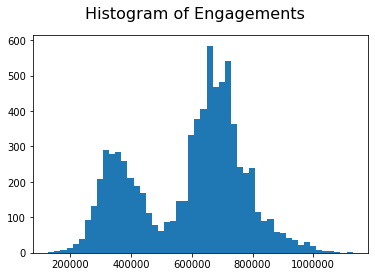

In [12]:
plt.hist(train['Engagements'],bins=50)
plt.suptitle('Histogram of Engagements', fontsize=16)

## Below are some exploratory plots that help us understand our data better. 

### Important observations:
- Video content rules. They see huge amount of fan engagement. Videos are the reason why the Engagements feature has two such peaks. The higher of the two peaks is due to videos.
- More engagement on Saturdays than any other day of the day. Could be because the games are live on ABC.
- The all star players generate much more engagement.
- Engagement in the off season is pretty low especially in July.
- Overusage of hashtags and mentions decreases engagement. The optimal number is at most 2.

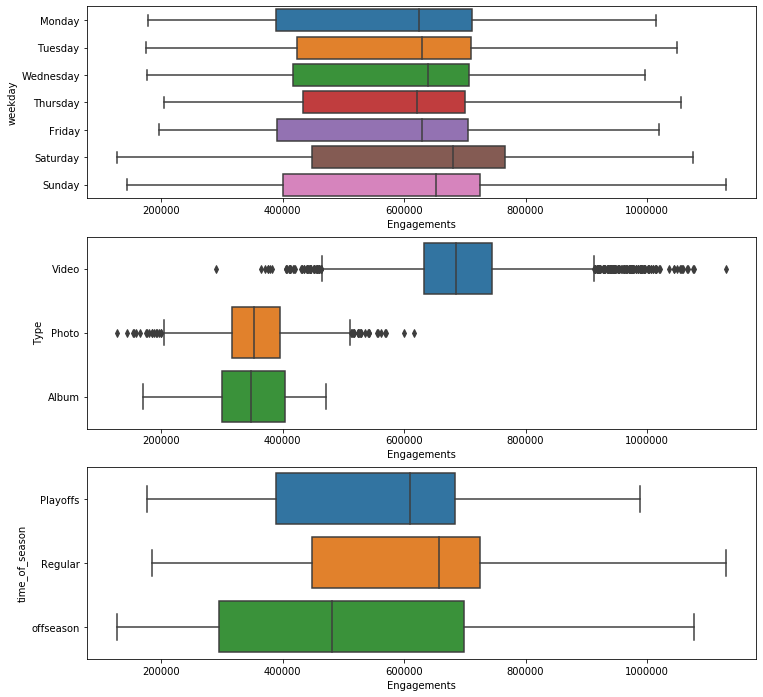

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(12,12))
order=["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"]
sns.boxplot(train['Engagements'],train['weekday'],order=order,ax=axes[0])
sns.boxplot('Engagements','Type',data=train,ax=axes[1])
sns.boxplot('Engagements','time_of_season',data=train,ax=axes[2])

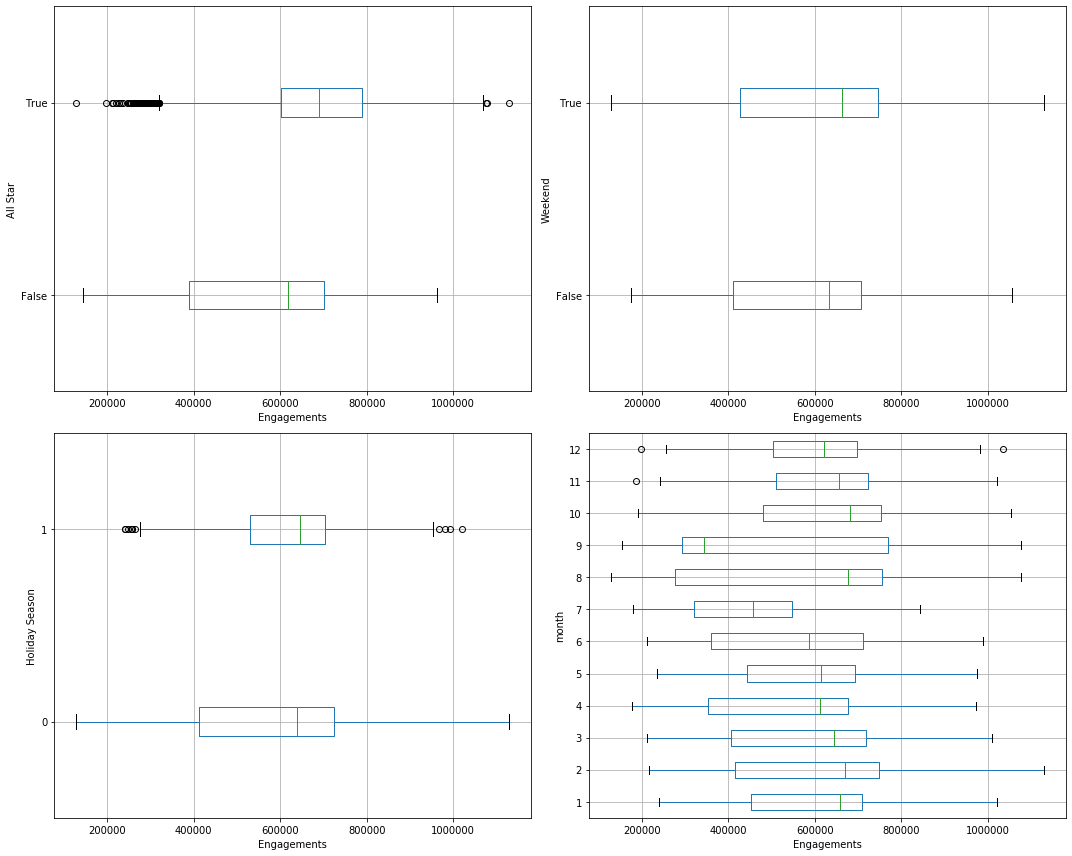

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,12))
#plt.subplots_adjust(hspace=0.5)

train.boxplot(column='Engagements',by='allstar_flag', patch_artist=False,vert=False,figsize=(5,5),grid = True,
              ax=axes[0,0])
axes[0,0].set(xlabel="Engagements", ylabel="All Star")
axes[0,0].set_title('')

train.boxplot(column='Engagements',by='weekend_flag', patch_artist=False,vert=False,figsize=(5,5),grid = True,
              ax=axes[0,1])
axes[0,1].set(xlabel="Engagements", ylabel="Weekend")
axes[0,1].set_title('')

train.boxplot(column='Engagements',by='holiday', patch_artist=False,vert=False,figsize=(5,5),grid = True,
              ax=axes[1,0])
axes[1,0].set(xlabel="Engagements", ylabel="Holiday Season")
axes[1,0].set_title('')


train.boxplot(column='Engagements',by='month', patch_artist=False,vert=False,figsize=(5,5),grid = True,
              ax=axes[1,1])
axes[1,1].set(xlabel="Engagements", ylabel="month")
axes[1,1].set_title('')

plt.suptitle("")
plt.tight_layout()

### The following plots give some insights into how engagements are across videos, photos and albums.

The key take away is that having an all star player in the post, or posting on a weekend definitely drives up engagement on the photos and videos but not in albums.

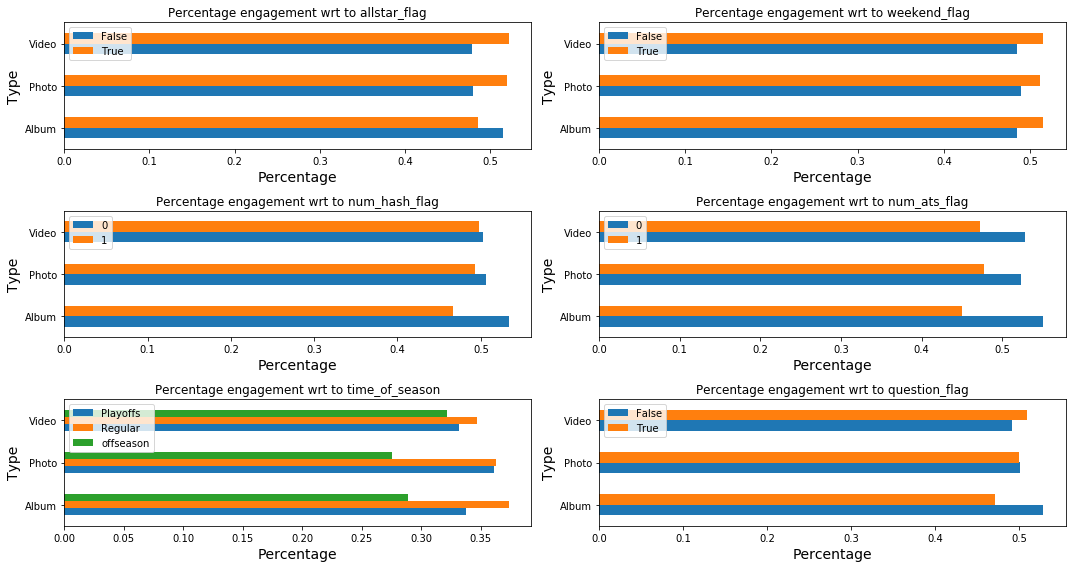

In [15]:
columns = ['allstar_flag','weekend_flag','num_hash_flag','num_ats_flag','time_of_season','question_flag']
fig = plt.figure(figsize=(15,8))
for i in range(0,len(columns)):
    d = train.groupby(['Type',columns[i]])['Engagements'].agg('mean')
    d = d / d.groupby(level=0).sum()
    ax = fig.add_subplot(3,2,i+1)
    d.unstack().plot.barh(ax=ax)
    plt.legend(loc=2)
    plt.xlabel('Percentage',fontsize = 14)
    plt.ylabel('Type',fontsize = 14)
    plt.title('Percentage engagement wrt to ' + columns[i])
plt.tight_layout()


Text(0.5, 1.0, 'Engagement across the entire day')

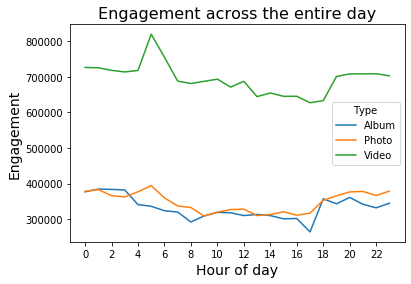

In [16]:
train.groupby(['time_of_day','Type'])['Engagements'].agg('mean').unstack().plot()
plt.xticks(np.arange(0, 24, step=2))
plt.ylabel('Engagement',fontsize =14)
plt.xlabel('Hour of day', fontsize = 14)
plt.title('Engagement across the entire day', fontsize = 16)

### Overusage of hashtags decreases engagement. The optimal number is at most 2.

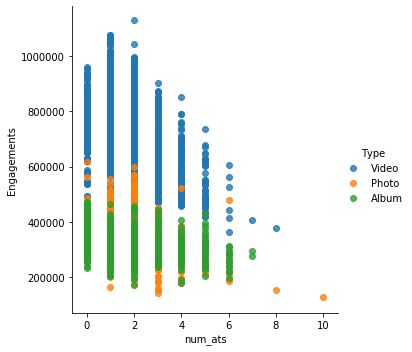

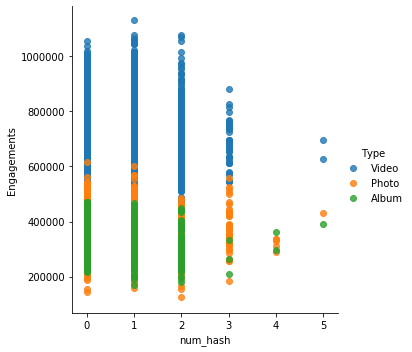

In [17]:
sns.lmplot( x="num_ats", y='Engagements',data=train ,fit_reg=False, hue='Type', legend=True)
sns.lmplot( x="num_hash", y='Engagements',data=train ,fit_reg=False, hue='Type', legend=True)

## Modeling

### Creating the features X and the taget variable Y.

In [18]:
X = train.drop(['Engagements', 'Created','Description','clean_desc'], axis = 1)
holdout_test = holdout_test.drop(['Engagements', 'Created','Description','clean_desc'], axis = 1)
Y = train['Engagements']
print('The shape of X is  {}'.format(X.shape))
print('The shape of holdout_test is {}'.format(holdout_test.shape))

The shape of X is  (7766, 19)
The shape of holdout_test is (1000, 19)


### Using sklearn's label encoder for encoding non integer data and then splitting into train, and test. Train = 80% and test = 20%

In [19]:
def datatype_convert(table):
    for column in table.columns:
        if table[column].dtype == type(object):
            le = preprocessing.LabelEncoder()
            table[column] = le.fit_transform(table[column])
    return table

X = datatype_convert(X)
holdout_test = datatype_convert(holdout_test)

print('The shape of X is {}'.format(X.shape))
print('The shape of holdout test is {}'.format(holdout_test.shape))

The shape of X is (7766, 19)
The shape of holdout test is (1000, 19)


In [20]:
x_tr, x_te,y_tr, y_te = train_test_split(X, Y, test_size = 0.2)

### Creating the metric mape as per the document provided with the challenge.

In [21]:
def mape(y_true,y_preds):
    total_samples = len(y_true)
    error_arr = np.divide(np.subtract(y_true,y_preds),y_true)
    abs_error = np.abs(error_arr)
    total_error = np.sum(abs_error)
    mape = np.divide(total_error,total_samples)
    return mape

### The modeling stage is divided into 3 parts : 
- Stage 1 : Try a linear regression model with only initial features i.e. Followers at Posting and the Type column.
- Stage 2 : Try a linear regression model with all new variables created above.
- Stage 3 : Try complex models like GBMs and random forests.
- Stage 4 : Validate model with 5 fold cross validation. Use charts to show which model performs best.

In [22]:
################### Stage 1 ###################
xtr_stage1 = x_tr[['Followers at Posting', 'Type']]
xte_stage1 = x_te[['Followers at Posting', 'Type']] 
lm_model_simple = LinearRegression()
lm_model_simple.fit(xtr_stage1,y_tr)
lm_model_simple_train_preds = lm_model_simple.predict(xtr_stage1)
print('The train mape for linear model with 2 features is {}'.format(mape(lm_model_simple_train_preds,y_tr)))
lm_model_simple_test_preds = lm_model_simple.predict(xte_stage1)
print('The test mape for linear model with 2 features is {}'.format(mape(lm_model_simple_test_preds,y_te)))

The train mape for linear model with 2 features is 0.1686791301633504
The test mape for linear model with 2 features is 0.16798208480205987


In [23]:
################### Stage 2 ###################
lm_model = LinearRegression()
lm_model.fit(x_tr,y_tr)
lm_model_train_preds = lm_model.predict(x_tr)
print('The train mape for linear regression (all vars) is {}'.format(mape(lm_model_train_preds,y_tr)))
lm_model_test_preds = lm_model.predict(x_te)
print('The test mape for linear regression (all vars) is {}'.format(mape(lm_model_test_preds,y_te)))

The train mape for linear regression (all vars) is 0.1749548396384928
The test mape for linear regression (all vars) is 0.15633165864076978


#### As can be derived from above scores, adding many more variables doesn't improve the model that much. But having more variables means that we can try complex emsemble methods.

The mape for gbm on train is 0.07258731205111296
The mape for gbm on test is 0.07465226038222847


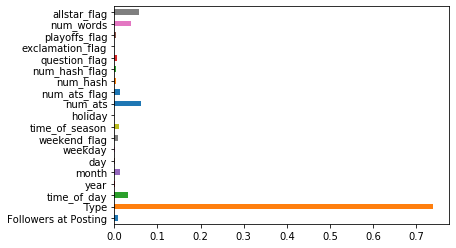

In [24]:
################### Stage 3 ###################
gbm = GradientBoostingRegressor(learning_rate = 0.01, 
                                n_estimators = 500, 
                                max_depth= 4,
                               max_features = 'sqrt',
                               min_samples_leaf = 50)
gbm.fit(x_tr,y_tr)
gbm_train_preds = gbm.predict(x_tr)
print('The mape for gbm on train is {}'.format(mape(gbm_train_preds,y_tr)))
gbm_test_preds = gbm.predict(x_te)
print('The mape for gbm on test is {}'.format(mape(gbm_test_preds,y_te)))

#Getting important features
feat_imp = pd.DataFrame(gbm.feature_importances_)
(pd.Series(gbm.feature_importances_, index=x_tr.columns).plot(kind='barh')) 

#### This feature importance plot also shows why adding so many variables didn't improve the model. The 'Type' variable is the biggest dominating variable and hence other features are getting squashed.

The mape for random forest on train is 0.10308025660267002
The mape for random forest on test is 0.10732893613027313


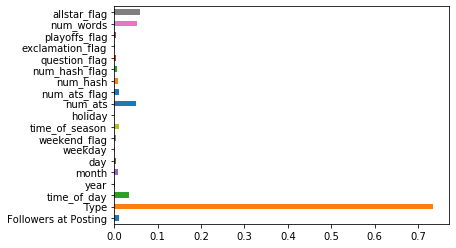

In [25]:
forest = RandomForestRegressor(n_estimators = 500,
                                max_leaf_nodes =25, 
                               max_features ='sqrt')
forest.fit(x_tr,y_tr)
forest_train_preds = forest.predict(x_tr)
print('The mape for random forest on train is {}'.format(mape(forest_train_preds,y_tr)))
forest_test_preds = forest.predict(x_te)
print('The mape for random forest on test is {}'.format(mape(forest_test_preds,y_te)))
(pd.Series(forest.feature_importances_, index=x_tr.columns).plot(kind='barh')) 

### Trying a model without adding the 'Type' feature to see how the gbm performs. It is very clear that the performance. From our exploratory plots, we can be sure that 

The train mape for gbm model without type feature is 0.20227294473093327
The test mape for gbm model without type feature is 0.21124043249877258


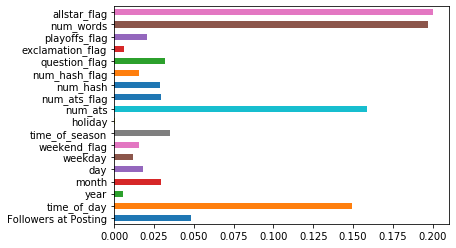

In [26]:
#Trying a model without the 'Type' feature.
xtr_notype = x_tr.drop(['Type'],axis=1)
xte_notype = x_te.drop(['Type'],axis=1)
gbm_notype = GradientBoostingRegressor(learning_rate = 0.01, 
                                n_estimators = 500, 
                                max_depth= 4,
                               max_features = 'sqrt',
                               min_samples_leaf = 50)
gbm_notype.fit(xtr_notype,y_tr)
gbm_notype_train_preds = gbm_notype.predict(xtr_notype)
print('The train mape for gbm model without type feature is {}'.format(mape(gbm_notype_train_preds,y_tr)))
gbm_notype_test_preds = gbm_notype.predict(xte_notype)
print('The test mape for gbm model without type feature is {}'.format(mape(gbm_notype_test_preds,y_te)))
(pd.Series(gbm_notype.feature_importances_, index=xtr_notype.columns).plot(kind='barh')) 

In [27]:
'''
This function plots the train and test scores in the same plot. 
Code from - https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
'''
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### We verify whether the GBM actually works across a 5 fold cross validation.

<module 'matplotlib.pyplot' from 'C:\\Users\\sabar\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

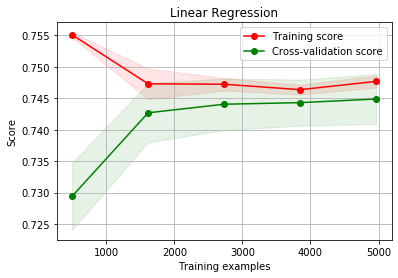

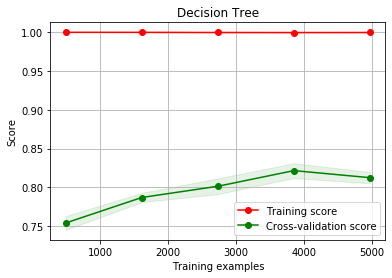

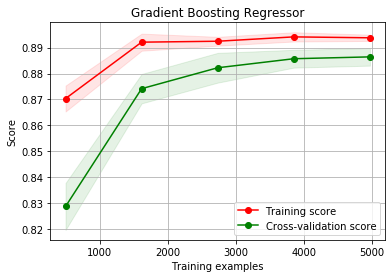

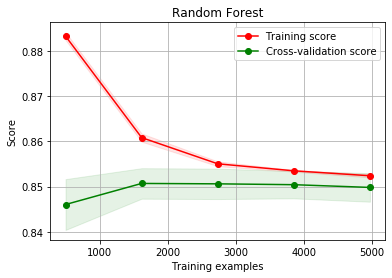

In [28]:
lm_model = LinearRegression()

decision_tree = DecisionTreeRegressor()

gbm = GradientBoostingRegressor(learning_rate = 0.01, 
                                n_estimators = 500, 
                                max_depth= 4,
                               max_features = 'sqrt',
                               min_samples_leaf = 50)


forest = RandomForestRegressor(n_estimators = 500,
                               max_leaf_nodes =25,
                               max_depth = 4)

plot_learning_curve(lm_model, 'Linear Regression', x_tr, y_tr)
plot_learning_curve(decision_tree, 'Decision Tree', x_tr, y_tr)
plot_learning_curve(gbm, 'Gradient Boosting Regressor', x_tr, y_tr)
plot_learning_curve(forest, 'Random Forest', x_tr, y_tr)

### To summarize, we tried 4 different models and the GBM and decision tree perform the best on the test set. Or do they? To verify, we will use cross_val_score from sklearn and plot the r2 metric. 

In [29]:
lm_model = LinearRegression()
decision_tree = DecisionTreeRegressor()

gbm = GradientBoostingRegressor(learning_rate = 0.01, 
                                n_estimators = 500, 
                                max_depth= 4,
                               max_features = 'sqrt',
                               min_samples_leaf = 50)



forest = RandomForestRegressor(n_estimators = 500,
                                max_leaf_nodes =25,
                               max_depth = 4)


models = {'LinearRegression':lm_model, 
          'DecisionTree': decision_tree,
          'GBM' : gbm,
          'RF' : forest
         }
                               
for name, model in models.items():
    model_obj = model.fit(x_tr,y_tr)
    preds = model_obj.predict(x_te)
    print('The metrics for the {} model is as below:'.format(name))
    print('MAPE: {}'.format(round(mape(preds,y_te),4)))

The metrics for the LinearRegression model is as below:
MAPE: 0.1563
The metrics for the DecisionTree model is as below:
MAPE: 0.0768
The metrics for the GBM model is as below:
MAPE: 0.0734
The metrics for the RF model is as below:
MAPE: 0.0913


In [30]:
results = []
names = []

for name, model in models.items():
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, x_tr, y_tr, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('Reports for the {} model are as below'.format(name))
    print('Avg RSquared = {}'.format(cv_results.mean()))
    print('Std dev of Avg RSquared score = {}'.format(cv_results.std()))

Reports for the LinearRegression model are as below
Avg RSquared = 0.7446765064973032
Std dev of Avg RSquared score = 0.007481377835297956
Reports for the DecisionTree model are as below
Avg RSquared = 0.815008196685967
Std dev of Avg RSquared score = 0.017001395798950575
Reports for the GBM model are as below
Avg RSquared = 0.8861368047084796
Std dev of Avg RSquared score = 0.0052835348994899525
Reports for the RF model are as below
Avg RSquared = 0.8489546757283716
Std dev of Avg RSquared score = 0.005598423215372805


### Seeing how the models performed across the 10 folds. GBMs have very low variability in their scores and perform the best.  

Text(0.5, 0.98, 'Variablility in the different models')

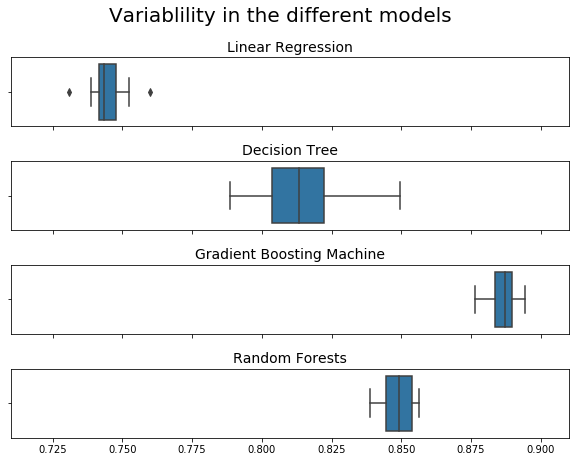

In [31]:
f, axes = plt.subplots(4, 1, sharex=True,sharey = True,figsize=(10,7))
f.subplots_adjust(hspace=.5)
plt.xlim(0.71, 0.91)
ax1 = sns.boxplot(results[0],ax = axes[0])
ax2 = sns.boxplot(results[1] ,ax = axes[1])
ax3 = sns.boxplot(results[2], ax = axes[2])
ax4 = sns.boxplot(results[3], ax = axes[3])
ax1.set_title('Linear Regression',fontsize = 14)
ax2.set_title('Decision Tree',fontsize = 14)
ax3.set_title('Gradient Boosting Machine',fontsize = 14)
ax4.set_title('Random Forests',fontsize = 14)
f.suptitle("Variablility in the different models", fontsize=20)

### GBM is going to be the best model in the case.
But what should be the final number of parameters in the GBM model? What should be the optimal number of trees and the best learning rate?


#### Note : 
We perform a grid search to get the least possible mape value.
There are a lot of parameters that we can optimize and I tried a variety of them but the n_trees, learning_rate, depth seemed to be more important than others and hence have shown a grid search for them below.

In [32]:
trees = [100,200,300,400,500,600,700,800,900,1000]
learning_rates = [0.01,0.001]
depths = [2,3,4]
least_mape = 100
best_model = None
best_params = {}
for tree in trees:
    for lr in learning_rates:
        for d in depths:
            print('Current model is tree = {}, lr = {}, depth ={}'.format(tree,lr,d))
            gbm_hyp_model = GradientBoostingRegressor(learning_rate = lr, 
                                                      n_estimators = tree, 
                                                      max_depth= d,
                                                      max_features = 'sqrt',
                                                      min_samples_leaf = 50)
            gbm_hyp_model.fit(x_tr,y_tr)
            preds = gbm_hyp_model.predict(x_tr)
            print('The mape for gbm on train is {}'.format(mape(preds,y_tr)))
            test_preds = gbm_hyp_model.predict(x_te)
            test_mape = mape(test_preds,y_te)
            print('The mape for gbm on test is {}'.format(test_mape))
            
            if test_mape < least_mape:
                least_mape = test_mape
                best_model = gbm_hyp_model
                best_params['ntrees'] = tree
                best_params['best_depth'] = d
                best_params['best_lr'] = lr


Current model is tree = 100, lr = 0.01, depth =2
The mape for gbm on train is 0.18673046297566492
The mape for gbm on test is 0.19030680696708904
Current model is tree = 100, lr = 0.01, depth =3
The mape for gbm on train is 0.1708769407935884
The mape for gbm on test is 0.17486666302406376
Current model is tree = 100, lr = 0.01, depth =4
The mape for gbm on train is 0.15733442615894155
The mape for gbm on test is 0.16126323946361812
Current model is tree = 100, lr = 0.001, depth =2
The mape for gbm on train is 0.24498598166200505
The mape for gbm on test is 0.24662524335522762
Current model is tree = 100, lr = 0.001, depth =3
The mape for gbm on train is 0.2423548475825757
The mape for gbm on test is 0.24408005378817632
Current model is tree = 100, lr = 0.001, depth =4
The mape for gbm on train is 0.24096498480612924
The mape for gbm on test is 0.2427698497511691
Current model is tree = 200, lr = 0.01, depth =2
The mape for gbm on train is 0.15213486242624594
The mape for gbm on test i

The mape for gbm on train is 0.061743178022115014
The mape for gbm on test is 0.065404668131383
Current model is tree = 1000, lr = 0.001, depth =2
The mape for gbm on train is 0.18716078457020013
The mape for gbm on test is 0.1905053267224484
Current model is tree = 1000, lr = 0.001, depth =3
The mape for gbm on train is 0.17064856713276494
The mape for gbm on test is 0.174554016689565
Current model is tree = 1000, lr = 0.001, depth =4
The mape for gbm on train is 0.15653048267810862
The mape for gbm on test is 0.16092215806304846


In [33]:
print('The best parameters are : {}'.format(best_params))

The best parameters are : {'ntrees': 1000, 'best_depth': 4, 'best_lr': 0.01}


### The above hyper parameter grid search basically said that the depth should be 4 and the learning rate shold be 0.01 and trees should be 1000. However, there is not much of a difference in the mape scores of the models at trees = 1000 and trees = 800. To verify this, plot the map scores as a function of the number of trees by fixing the dept at 4 and the learning rate at 0.01

We can lock the depth and the learning rate and experiment with the number of trees to see the mape score. In this way we can try to find the optimal number of trees to build for our model.

In [34]:
trees = range(100, 2500, 100)
least_mape = 100
best_model = None
train_errors = []
test_errors = []
for tree in trees:
    print('Current model is tree = {}'.format(tree))
    gbm_hyp_model = GradientBoostingRegressor(learning_rate = 0.01, 
                                              n_estimators = tree, 
                                              max_depth= 4,
                                              max_features = 'sqrt',
                                              min_samples_leaf = 50)
    gbm_hyp_model.fit(x_tr,y_tr)
    preds = gbm_hyp_model.predict(x_tr)
    train_mape = mape(preds,y_tr)
    print('The mape for gbm on train is {}'.format(train_mape))
    test_preds = gbm_hyp_model.predict(x_te)
    test_mape = mape(test_preds,y_te)
    print('The mape for gbm on test is {}'.format(test_mape))
    train_errors.append(train_mape)
    test_errors.append(test_mape)
    


Current model is tree = 100
The mape for gbm on train is 0.15460888060489844
The mape for gbm on test is 0.15887849443615534
Current model is tree = 200
The mape for gbm on train is 0.10895153826746941
The mape for gbm on test is 0.11278902960571041
Current model is tree = 300
The mape for gbm on train is 0.08782988710818651
The mape for gbm on test is 0.09019094751504625
Current model is tree = 400
The mape for gbm on train is 0.07838155433284805
The mape for gbm on test is 0.07972100582977065
Current model is tree = 500
The mape for gbm on train is 0.07233874298916168
The mape for gbm on test is 0.07481150572486149
Current model is tree = 600
The mape for gbm on train is 0.06833150945169869
The mape for gbm on test is 0.07025129247201009
Current model is tree = 700
The mape for gbm on train is 0.06639666708342307
The mape for gbm on test is 0.06881931539477326
Current model is tree = 800
The mape for gbm on train is 0.06390629425726804
The mape for gbm on test is 0.06698115594290391


### Plotting the reduction in error as we keep adding more trees to the GBM. 

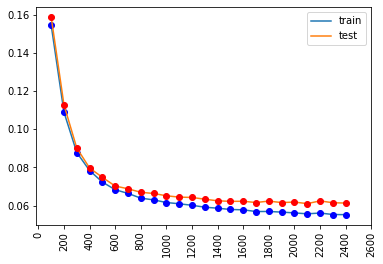

In [35]:
traindata = list(zip(trees, train_errors))
trx_val = [x[0] for x in traindata]
try_val = [x[1] for x in traindata]
testdata = list(zip(trees, test_errors))
tex_val = [x[0] for x in testdata]
tey_val = [x[1] for x in testdata]


plt.plot(trx_val,try_val, label = 'train')
plt.plot(trx_val,try_val,'ob')

plt.plot(tex_val,tey_val,label = 'test')
plt.plot(tex_val,tey_val,'or')

plt.xticks(np.arange(0, 2800, step=200),rotation='vertical')
plt.legend()

### The model basically stops learning at around 600~800 trees. Keeping in mind that the dataset is quite small and the reduction in the error is in the 3rd digit after the decimal point, I will only build 700 trees in my final model. 

### The final model parameters are : 

- trees = 700
- learning_rate = 0.01
- max_depth = 4
- max_features = square root of the total number of features
- max leaf nodes = 50

In [36]:
final_gbm_model = GradientBoostingRegressor(learning_rate = 0.01, 
                                              n_estimators = 700, 
                                              max_depth= 4,
                                              max_features = 'sqrt',
                                              min_samples_leaf = 50)
final_gbm_model.fit(X,Y)
gbm_train_preds = gbm.predict(x_tr)
gbm_test_preds = gbm.predict(x_te)
print('The mape train is {}'.format(mape(gbm_train_preds,y_tr)))
print('The mape train is {}'.format(mape(gbm_test_preds,y_te)))


filename = 'holdout_set_Sabarish_Gopalakrishnan.csv'
print('Writing the final predictions into {}'.format(filename))
gbm_holdout_preds = gbm.predict(holdout_test)
np.savetxt(filename, gbm_holdout_preds, header = 'Engagements')

The mape train is 0.07176700408128087
The mape train is 0.07337813229192941
Writing the final predictions into holdout_set_Sabarish_Gopalakrishnan.csv


#### I plot the histogram of all the predictions to ensure they all look similar

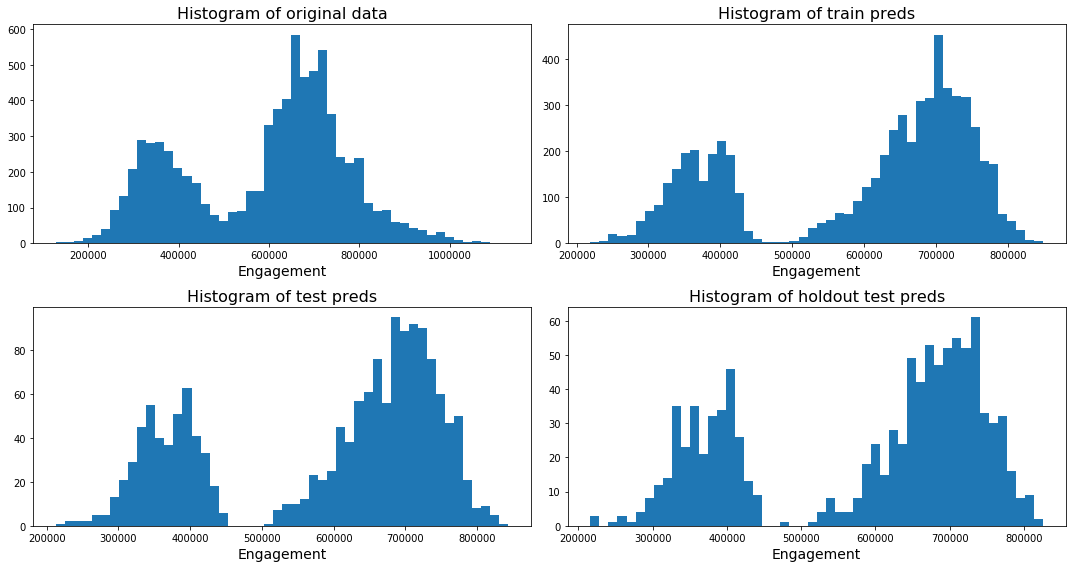

In [37]:
fig = plt.figure(figsize=(15,8))
ys = [train['Engagements'],gbm_train_preds, gbm_test_preds, gbm_holdout_preds]
for i in range(0,len(ys)):
    ax = fig.add_subplot(2,2,i+1)
    plt.hist(ys[i], bins = 50)
    plt.xlabel('Engagement',fontsize = 14)
    if i == 0:
        title_font = 'Histogram of original data'
    if i == 1:
        title_font = 'Histogram of train preds'
    if i == 2:
        title_font = 'Histogram of test preds'
    if i == 3:
        title_font = 'Histogram of holdout test preds'
    plt.title(title_font, fontsize = 16)
plt.tight_layout()